# Does variation in q(z) greatly impact the returned parameters?




In [1]:
# system
import sys, os
sys.path.insert(0,'../BIVI/')

# timing
import time

# numbers
import numpy as np
import torch

# sc 
import scanpy as sc
import anndata


# plots
import matplotlib.pyplot as plt

# # biVI
import biVI
import scvi
print(scvi.__version__)

# # reproducibility
scvi._settings.ScviConfig.seed=(12623)
torch.manual_seed(12623)
np.random.seed(12623)

Global seed set to 0
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


0.18.0


In [2]:
# first load in data
adata = anndata.read_loom('../data/allen/B08_processed_hv.loom')

# make variable names unique 
adata.var_names_make_unique()

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
# define models

# # biVI
# model1 = biVI.biVI(train_adata,mode='Bursty',**model_args)

# # scVI
# model2 = scvi.model.SCVI(train_adata,**model_args)

# model1.train(max_epochs = epochs,
#                 train_size = 0.9,
#                 check_val_every_n_epoch  = 1,
#                 plan_kwargs = plan_kwargs)

# model2.train(max_epochs = epochs,
#                 train_size = 0.9,
#                 check_val_every_n_epoch  = 1,
#                 plan_kwargs = plan_kwargs)

# # Save models
# model1.save('./biVI_model_B08',overwrite=True)
# model2.save('./scVI_model_B08',overwrite=True)

In [4]:
# load in models
model1 = biVI.biVI.load("../results/Bursty_B08_processed_hv_MODEL", adata=adata, use_gpu = True)
model2 = scvi.model.SCVI.load("../results/scVI_B08_processed_hv_MODEL", adata=adata, use_gpu = True)

INFO     File ../../results/Bursty_B08_processed_hv_MODEL/model.pt already downloaded                              
{'n_input': 4000, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear
INFO     File ../../results/scVI_B08_processed_hv_MODEL/model.pt already downloaded                                


/home/tara/.local/lib/python3.8/site-packages/scvi/model/base/_utils.py:142: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(
/home/tara/.local/lib/python3.8/site-packages/scvi/model/base/_utils.py:142: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(


Get likelihood parameters and normalized expression parameters.


Use testing data. 

In [5]:
biVI_parameters = model1.get_likelihood_parameters(adata[:100],n_samples = 50);
biVI_norm_parameters = model1.get_normalized_expression(adata[:100],n_samples = 50);

scVI_parameters = model2.get_likelihood_parameters(adata[:100],n_samples = 50,
                                                  give_mean = False);
scVI_norm_parameters = model2.get_normalized_expression(adata[:100],n_samples = 50, return_numpy = True, 
                                                  return_mean = False);

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Bursty mode, getting parameters
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


# Plotting parameters over samples from Q(z)


Choose several genes, plot the sampled parameters. 


In [16]:
cell_indices = np.random.choice(np.arange(100),size=30,replace=False)
gene_indices = np.random.choice(np.arange(2000),size=30,replace=False)
gene_names = adata.var['gene_name'][gene_indices]

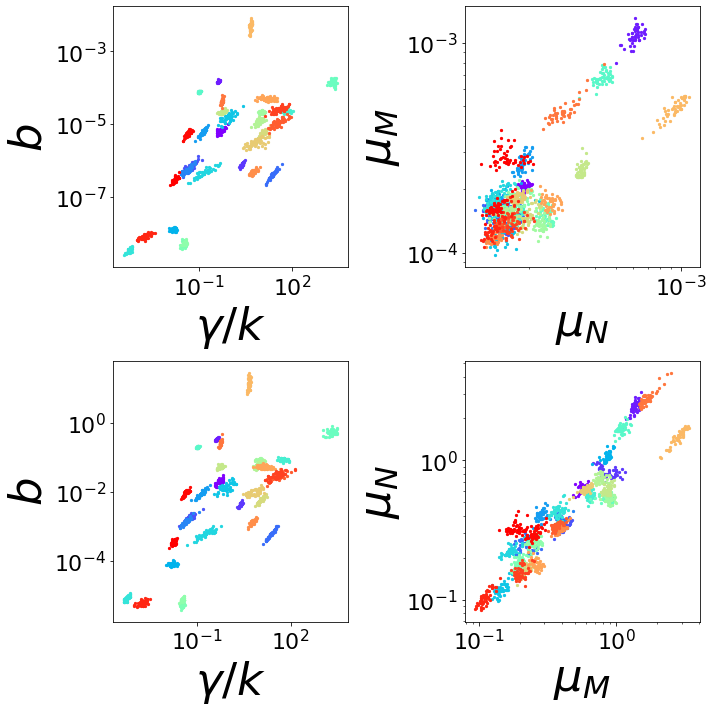

In [17]:
# Normalized, biVI


fs = 45
fig,ax = plt.subplots(2,2,figsize=(10,10))

for i,g in enumerate(gene_indices):
    
    cell_index = cell_indices[i]
    color = plt.get_cmap('rainbow')(i*9)
    mu1_norm = scVI_norm_parameters[:,:,:2000]
    mu2_norm = scVI_norm_parameters[:,:,2000:]
    b_norm = biVI_norm_parameters['norm_burst_size'] 
    gamma_norm = biVI_norm_parameters['norm_degradation_rate']
    
    
    mu1 = scVI_parameters['mean'][:,:,:2000] 
    mu2 = scVI_parameters['mean'][:,:,2000:]
    b = biVI_parameters['burst_size'] 
    gamma = biVI_parameters['rel_degradation_rate']
    
    ax[0,0].scatter(gamma_norm[:,cell_index,g],b_norm[:,cell_index,g],s=5,color=color)
    ax[0,0].set_xlabel('$\gamma/k$', fontsize = fs)
    ax[0,0].set_ylabel('$b$', fontsize = fs)
    ax[0,0].set_yscale('log')
    ax[0,0].set_xscale('log')
    ax[0,0].tick_params(axis='both', which='major', labelsize=22)
    ax[0,0].tick_params(axis='both', which='minor', labelsize=10)
    
    
    ax[0,1].scatter(mu1_norm[:,cell_index,g],mu2_norm[:,cell_index,g], label = gene_names[i],s=5,color=color)
    ax[0,1].set_xlabel('$\mu_N$', fontsize = fs)
    ax[0,1].set_ylabel('$\mu_M$', fontsize = fs)
    ax[0,1].set_yscale('log')
    ax[0,1].set_xscale('log')
    ax[0,1].tick_params(axis='both', which='major', labelsize=22)
    ax[0,1].tick_params(axis='both', which='minor', labelsize=10)
    
    
    ax[1,0].scatter(gamma[:,cell_index,g],b[:,cell_index,g],s=5,color=color)
    ax[1,0].set_xlabel('$\gamma/k$', fontsize = fs)
    ax[1,0].set_ylabel('$b$', fontsize = fs)
    ax[1,0].set_yscale('log')
    ax[1,0].set_xscale('log')
    ax[1,0].tick_params(axis='both', which='major', labelsize=22)
    ax[1,0].tick_params(axis='both', which='minor', labelsize=10)
        
    ax[1,1].scatter(mu1[:,cell_index,g],mu2[:,cell_index,g], label = gene_names[i],s=5,color=color)
    ax[1,1].set_xlabel('$\mu_M$', fontsize = fs)
    ax[1,1].set_ylabel('$\mu_N$', fontsize = fs)
    ax[1,1].set_yscale('log')
    ax[1,1].set_xscale('log')
    ax[1,1].tick_params(axis='both', which='major', labelsize=22)
    ax[1,1].tick_params(axis='both', which='minor', labelsize=10)
       
    
#plt.legend(bbox_to_anchor=(1.0, 1.0))
# plt.ticklabel_format(axis="both", style="sci")

# plt.suptitle(f'biVI, normalized, Cell # {cell_index}', fontsize = fs)
plt.tight_layout()

plt.savefig('../results/B08_processed_hv_figs/sampled_param_scatter.png',bbox_inches='tight')

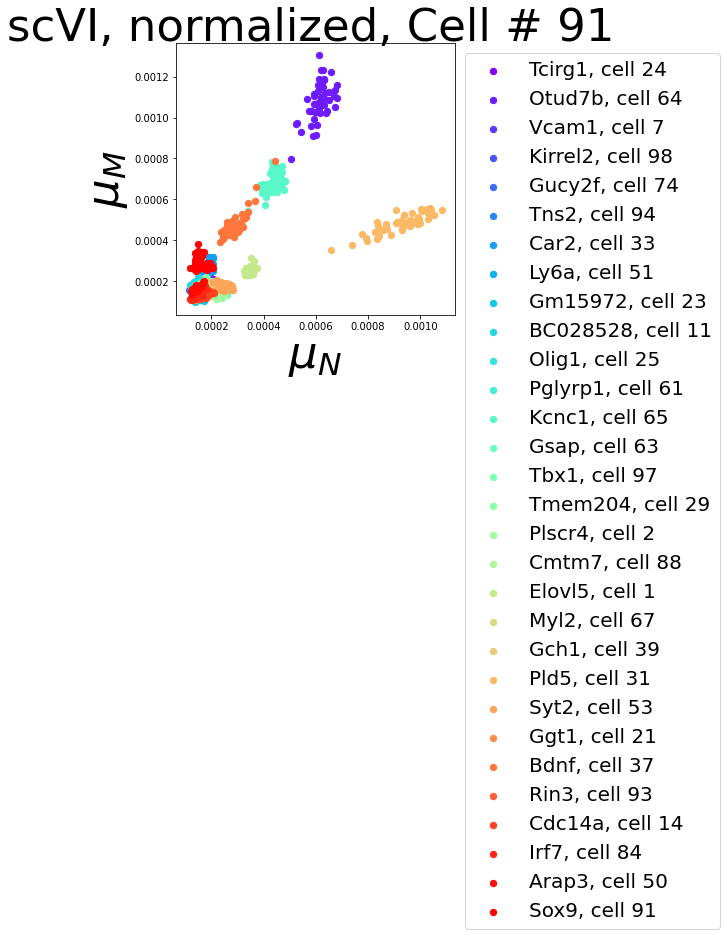

In [18]:
# Normalized, scVI
fig,ax = plt.subplots(1,1,figsize=(5,5))

for i,g in enumerate(gene_indices):
    cell_index = cell_indices[i]
    color = plt.get_cmap('rainbow')(i*9)
    mu1 = scVI_norm_parameters[:,cell_index,g]
    mu2 = scVI_norm_parameters[:,cell_index,g+2000]
    name_ = gene_names[i]
    ax.scatter(mu1, mu2, label = f'{name_}, cell {cell_index}', s=40, color=color)
    ax.set_xlabel('$\mu_N$', fontsize = fs)
    ax.set_ylabel('$\mu_M$', fontsize = fs)

plt.legend(bbox_to_anchor=(1.0, 1.0),fontsize=20)
# plt.ticklabel_format(axis="both", style="sci")
plt.suptitle(f'scVI, normalized, Cell # {cell_index}',fontsize = fs)

plt.savefig('../results/B08_processed_hv_figs/sampled_param_label.png',bbox_inches='tight')

### Trajectories

How long does it take each to converge?

In [19]:
def get_param_mean_trajectories(array):
    ''' Returns an array with the mean of each parameter tracked over the samples.
    Input
    -------
    array
        shape (n_samples, n_cells, n_genes)
    
    Output
    -------
    mean_trajectories
        shape(n_samples, n_cells, n_genes) where ith n_sample now stores the mean of the parameter
            over the samples from 0 to i
    '''
    
    mean_trajectories = np.empty_like(array,dtype = float)
    
    for i in range(np.shape(array)[0]):
        
        mean_trajectories[i,:,:] = np.mean(array[:i+1,:,:],axis=0)
    
    return mean_trajectories
        
        

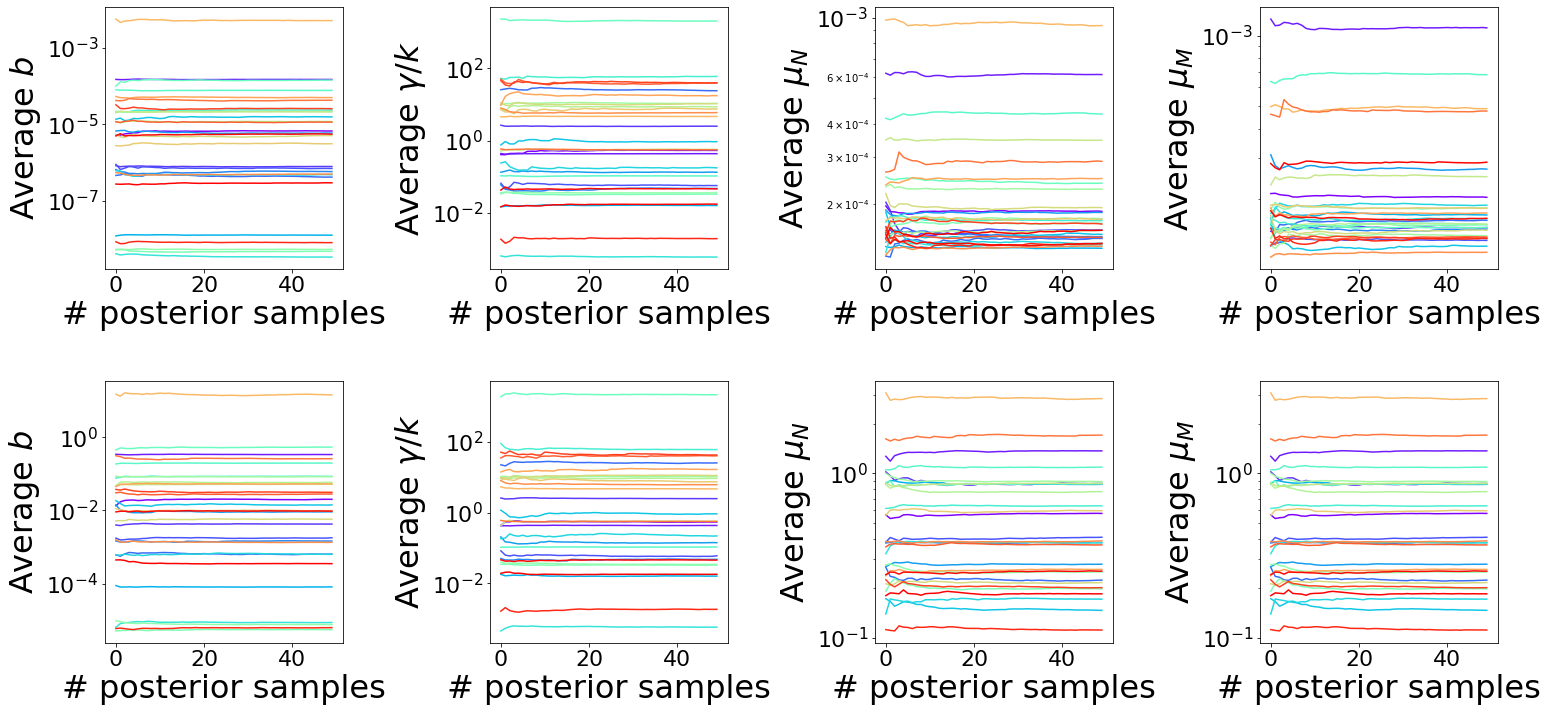

In [20]:
# PLOT
fs = 32
fig,ax = plt.subplots(2,4,figsize=(21,10))
mu1_norm = get_param_mean_trajectories(scVI_norm_parameters[:,:,:2000])
mu2_norm = get_param_mean_trajectories(scVI_norm_parameters[:,:,2000:]) 
b_norm = get_param_mean_trajectories(biVI_norm_parameters['norm_burst_size']) 
gamma_norm = get_param_mean_trajectories(biVI_norm_parameters['norm_degradation_rate'])


mu1 = get_param_mean_trajectories(scVI_parameters['mean'][:,:,:2000])
mu2 = get_param_mean_trajectories(scVI_parameters['mean'][:,:,:2000])
b = get_param_mean_trajectories(biVI_parameters['burst_size']) 
gamma = get_param_mean_trajectories(biVI_parameters['rel_degradation_rate'])

for i,g in enumerate(gene_indices):
    
    cell_index = cell_indices[i]
    color = plt.get_cmap('rainbow')(i*9)
    
    ax[0,0].plot(range(50),b_norm[:,cell_index,g],color=color)
    ax[0,0].set_xlabel('# posterior samples', fontsize = fs)
    ax[0,0].set_ylabel('Average $b$', fontsize = fs)
#     ax[0,0].set_title('$b$', fontsize = fs)
    ax[0,0].set_yscale('log')
    ax[0,0].tick_params(axis='both', which='major', labelsize=22)
    ax[0,0].tick_params(axis='both', which='minor', labelsize=10)
    
    
    ax[0,1].plot(range(50),gamma_norm[:,cell_index,g],color=color)
    ax[0,1].set_xlabel('# posterior samples', fontsize = fs)
    ax[0,1].set_ylabel('Average $\gamma/k$', fontsize = fs)
    ax[0,1].set_yscale('log')
#     ax[1].set_title('$\gamma/k$', fontsize = fs)
    ax[0,1].tick_params(axis='both', which='major', labelsize=22)
    ax[0,1].tick_params(axis='both', which='minor', labelsize=10)
    
    ax[0,2].plot(range(50),mu1_norm[:,cell_index,g],color=color)
    ax[0,2].set_xlabel('# posterior samples', fontsize = fs)
    ax[0,2].set_ylabel('Average $\mu_N$', fontsize = fs)
    ax[0,2].set_yscale('log')
#     ax[1,0].set_title('$\mu_1$', fontsize = fs)
    ax[0,2].tick_params(axis='both', which='major', labelsize=22)
    ax[0,2].tick_params(axis='both', which='minor', labelsize=10)
    
    ax[0,3].plot(range(50),mu2_norm[:,cell_index,g],color=color)
    ax[0,3].set_xlabel('# posterior samples', fontsize = fs)
    ax[0,3].set_ylabel('Average $\mu_M$', fontsize = fs)
    ax[0,3].set_yscale('log')
#     ax[1,1].set_title('$\mu_2$', fontsize = fs)
    ax[0,3].tick_params(axis='both', which='major', labelsize=22)
    ax[0,3].tick_params(axis='both', which='minor', labelsize=10)

    ax[1,0].plot(range(50),b[:,cell_index,g],color=color)
    ax[1,0].set_xlabel('# posterior samples', fontsize = fs)
    ax[1,0].set_ylabel('Average $b$', fontsize = fs)
#     ax[1,0].set_title('$b$', fontsize = fs)
    ax[1,0].set_yscale('log')
    ax[1,0].tick_params(axis='both', which='major', labelsize=22)
    ax[1,0].tick_params(axis='both', which='minor', labelsize=10)
    
    ax[1,1].plot(range(50),gamma[:,cell_index,g],color=color)
    ax[1,1].set_xlabel('# posterior samples', fontsize = fs)
    ax[1,1].set_ylabel('Average $\gamma/k$', fontsize = fs)
    ax[1,1].set_yscale('log')
#     ax[1].set_title('$\gamma/k$', fontsize = fs)
    ax[1,1].tick_params(axis='both', which='major', labelsize=22)
    ax[1,1].tick_params(axis='both', which='minor', labelsize=10)
    
    ax[1,2].plot(range(50),mu1[:,cell_index,g],color=color)
    ax[1,2].set_xlabel('# posterior samples', fontsize = fs)
    ax[1,2].set_ylabel('Average $\mu_N$', fontsize = fs)
    ax[1,2].set_yscale('log')
#     ax[1,0].set_title('$\mu_1$', fontsize = fs)
    ax[1,2].tick_params(axis='both', which='major', labelsize=22)
    ax[1,2].tick_params(axis='both', which='minor', labelsize=10)
    
    ax[1,3].plot(range(50),mu2[:,cell_index,g],color=color)
    ax[1,3].set_xlabel('# posterior samples', fontsize = fs)
    ax[1,3].set_ylabel('Average $\mu_M$', fontsize = fs)
    ax[1,3].set_yscale('log')
#     ax[1,1].set_title('$\mu_2$', fontsize = fs)
    ax[1,3].tick_params(axis='both', which='major', labelsize=22)
    ax[1,3].tick_params(axis='both', which='minor', labelsize=10)
    

#plt.legend(bbox_to_anchor=(1.0, 1.0))
# plt.ticklabel_format(axis="both", style="sci")

#plt.suptitle(f'biVI, normalized, Cell # {cell_index}', fontsize = fs)
plt.tight_layout(h_pad=5, w_pad=5)

plt.savefig('../results/B08_processed_hv_figs/sampled_param_trajectories.png',bbox_inches='tight')

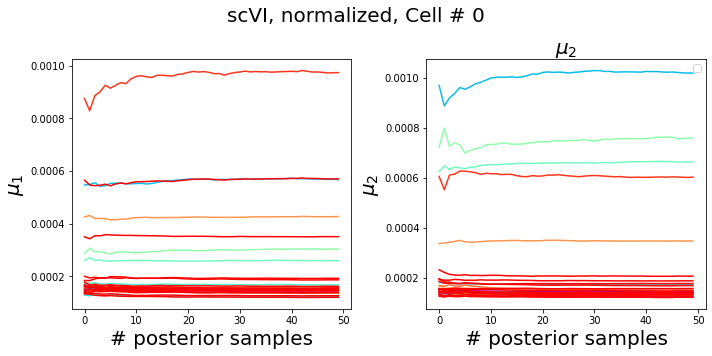

In [22]:
# fs = 20
# fig,ax = plt.subplots(1,2,figsize=(10,5))
# mu = get_param_mean_trajectories(scVI_norm_parameters)

# for i,g in enumerate(gene_indices):
#     color = plt.get_cmap('rainbow')(i*17)

    
#     ax[0].plot(range(50),mu[:,cell_index,g],color=color)
#     ax[0].set_xlabel('# posterior samples', fontsize = fs)
#     ax[0].set_ylabel('$\mu_1$', fontsize = fs)
    
#     ax[1].plot(range(50),mu[:,cell_index,g+2000],color=color)
#     ax[1].set_xlabel('# posterior samples', fontsize = fs)
#     ax[1].set_ylabel('$\mu_2$', fontsize = fs)
#     ax[1].set_title('$\mu_2$', fontsize = fs)

# plt.legend(bbox_to_anchor=(1.0, 1.0))
# plt.ticklabel_format(axis="both", style="sci")

# plt.suptitle(f'scVI, normalized, Cell # {cell_index}', fontsize = fs)
# plt.tight_layout()

### Adding "library size" $l$

Does this increase variance in mean value?

Text(0.5, 0.98, 'biVI, UN-Normalized Cell # 0')

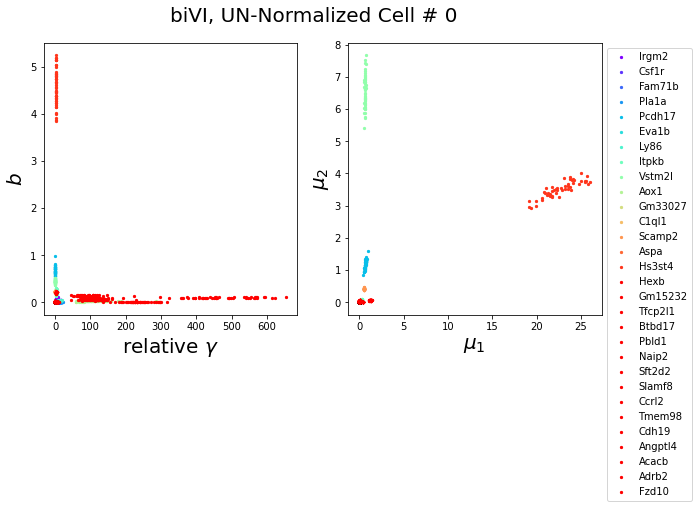

In [23]:
# # Un-normalized
# fig,ax = plt.subplots(1,2,figsize=(10,5))
# for i,g in enumerate(gene_indices):
#     color = plt.get_cmap('rainbow')(i*17)
#     mu1 = biVI_parameters['unspliced_means'] 
#     mu2 = biVI_parameters['spliced_means'] 
#     b = biVI_parameters['burst_size'] 
#     gamma = biVI_parameters['rel_degradation_rate']
#     ax[0].scatter(gamma[:,cell_index,g],b[:,cell_index,g],s=5,color=color)
#     ax[0].set_xlabel('relative $\gamma$', fontsize = fs)
#     ax[0].set_ylabel('$b$', fontsize = fs)
    
#     ax[1].scatter(mu1[:,cell_index,g],mu2[:,cell_index,g], label = gene_names[i],s=5,color=color)
#     ax[1].set_xlabel('$\mu_1$',fontsize = fs)
#     ax[1].set_ylabel('$\mu_2$', fontsize = fs)

# plt.legend(bbox_to_anchor=(1.0, 1.0))
# plt.suptitle(f'biVI, UN-Normalized Cell # {cell_index}', fontsize = fs)

Text(0.5, 0.98, 'scVI, UN-normalized, Cell # 0')

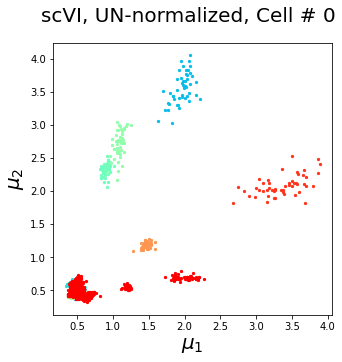

In [27]:
# UNormalized, scVI
fig,ax = plt.subplots(1,1,figsize=(5,5))

for i,g in enumerate(gene_indices):
    color = plt.get_cmap('rainbow')(i*17)
    mu1 = scVI_parameters['mean'][:,cell_index,g]
    mu2 = scVI_parameters['mean'][:,cell_index,g+2000]
    
    ax.scatter(mu1, mu2, label = gene_names[i], s=5, color=color)
    ax.set_xlabel('$\mu_1$', fontsize = fs)
    ax.set_ylabel('$\mu_2$', fontsize = fs)

#plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.ticklabel_format(axis="both", style="sci")
# plt.suptitle(f'scVI, UN-normalized, Cell # {cell_index}',fontsize = fs)

### And mean of parameters over samples again, this time with sequencing depth

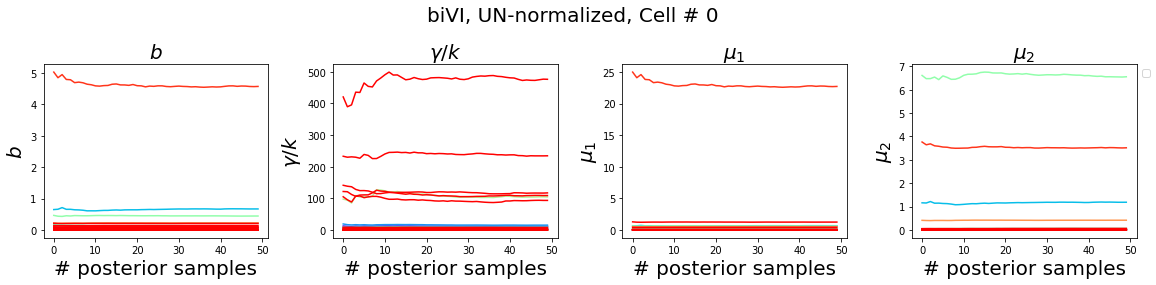

In [25]:
# PLOT

fig,ax = plt.subplots(1,4,figsize=(16,4))
mu1 = get_param_mean_trajectories(biVI_parameters['unspliced_means'])
mu2 = get_param_mean_trajectories(biVI_parameters['spliced_means']) 
b = get_param_mean_trajectories(biVI_parameters['burst_size']) 
gamma = get_param_mean_trajectories(biVI_parameters['rel_degradation_rate'])

for i,g in enumerate(gene_indices):
    color = plt.get_cmap('rainbow')(i*17)
    
    ax[0].plot(range(50),b[:,cell_index,g],color=color)
    ax[0].set_xlabel('# posterior samples', fontsize = fs)
    ax[0].set_ylabel('$b$', fontsize = fs)
    ax[0].set_title('$b$', fontsize = fs)
    
    ax[1].plot(range(50),gamma[:,cell_index,g],color=color)
    ax[1].set_xlabel('# posterior samples', fontsize = fs)
    ax[1].set_ylabel('$\gamma/k$', fontsize = fs)
    ax[1].set_title('$\gamma/k$', fontsize = fs)
    
    ax[2].plot(range(50),mu1[:,cell_index,g],color=color)
    ax[2].set_xlabel('# posterior samples', fontsize = fs)
    ax[2].set_ylabel('$\mu_1$', fontsize = fs)
    ax[2].set_title('$\mu_1$', fontsize = fs)
    
    ax[3].plot(range(50),mu2[:,cell_index,g],color=color)
    ax[3].set_xlabel('# posterior samples', fontsize = fs)
    ax[3].set_ylabel('$\mu_2$', fontsize = fs)
    ax[3].set_title('$\mu_2$', fontsize = fs)
    

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.ticklabel_format(axis="both", style="sci")

plt.suptitle(f'biVI, UN-normalized, Cell # {cell_index}', fontsize = fs)
plt.tight_layout()

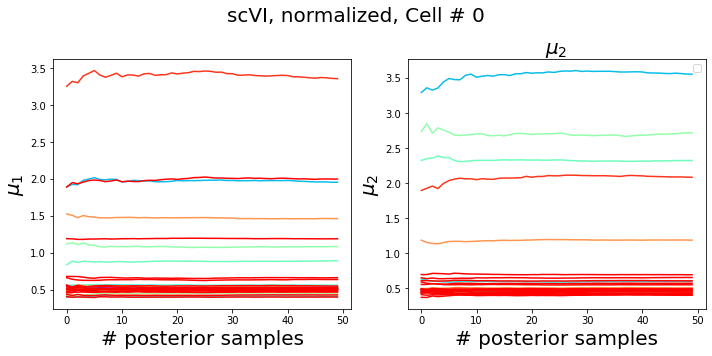

In [26]:
fs = 20
fig,ax = plt.subplots(1,2,figsize=(10,5))
mu = get_param_mean_trajectories(scVI_parameters['mean'])


for i,g in enumerate(gene_indices):
    color = plt.get_cmap('rainbow')(i*17)

    
    ax[0].plot(range(50),mu[:,cell_index,g],color=color)
    ax[0].set_xlabel('# posterior samples', fontsize = fs)
    ax[0].set_ylabel('$\mu_1$', fontsize = fs)
    
    ax[1].plot(range(50),mu[:,cell_index,g+2000],color=color)
    ax[1].set_xlabel('# posterior samples', fontsize = fs)
    ax[1].set_ylabel('$\mu_2$', fontsize = fs)
    ax[1].set_title('$\mu_2$', fontsize = fs)

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.ticklabel_format(axis="both", style="sci")

plt.suptitle(f'scVI, normalized, Cell # {cell_index}', fontsize = fs)
plt.tight_layout()

# Mean of parameter vs. variation of parameter



In [568]:
biVI_norm_parameters.keys()

dict_keys(['norm_unspliced', 'norm_spliced', 'norm_burst_size', 'norm_degradation_rate'])

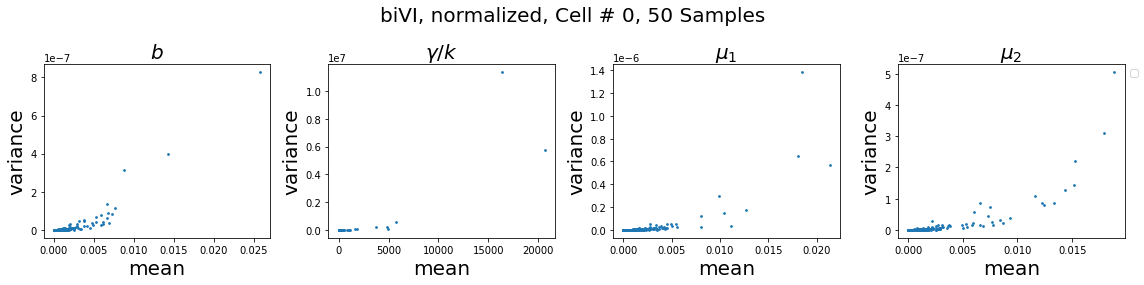

In [572]:
# biVI, NORMALIZED

# PLOT

fig,ax = plt.subplots(1,4,figsize=(16,4))
mu1 = biVI_norm_parameters['norm_spliced']
mu2 = biVI_norm_parameters['norm_unspliced']
b = biVI_norm_parameters['norm_burst_size']
gamma = biVI_norm_parameters['norm_degradation_rate']

    
ax[0].scatter(np.mean(b[:,cell_index,:],axis=0),np.var(b[:,cell_index,:],axis=0),s = 3)
ax[0].set_xlabel('mean', fontsize = fs)
ax[0].set_ylabel('variance', fontsize = fs)
ax[0].set_title('$b$', fontsize = fs)

ax[1].scatter(np.mean(gamma[:,cell_index,:],axis=0),np.var(gamma[:,cell_index,:],axis=0),s = 3)
ax[1].set_xlabel('mean', fontsize = fs)
ax[1].set_ylabel('variance', fontsize = fs)
ax[1].set_title('$\gamma/k$', fontsize = fs)

ax[2].scatter(np.mean(mu1[:,cell_index,:],axis=0),np.var(mu1[:,cell_index,:],axis=0),s = 3)
ax[2].set_xlabel('mean', fontsize = fs)
ax[2].set_ylabel('variance', fontsize = fs)
ax[2].set_title('$\mu_1$', fontsize = fs)

ax[3].scatter(np.mean(mu2[:,cell_index,:],axis=0),np.var(mu2[:,cell_index,:],axis=0),s = 3)
ax[3].set_xlabel('mean', fontsize = fs)
ax[3].set_ylabel('variance', fontsize = fs)
ax[3].set_title('$\mu_2$', fontsize = fs)

    

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.ticklabel_format(axis="both", style="sci")

plt.suptitle(f'biVI, normalized, Cell # {cell_index}, 50 Samples', fontsize = fs)
plt.tight_layout()

And trajectory of mean of params over the samples. 

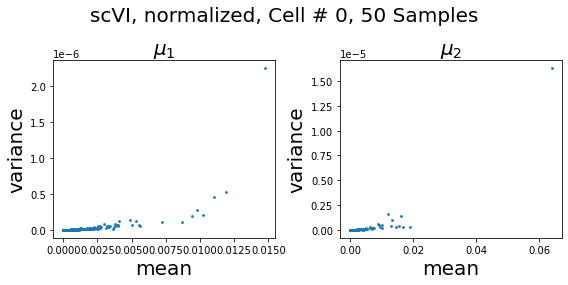

In [582]:
# scVI, NORMALIZED

# PLOT

fig,ax = plt.subplots(1,2,figsize=(8,4))
mu = scVI_norm_parameters


    
ax[0].scatter(np.mean(mu[:,cell_index,:2000],axis=0),np.var(mu[:,cell_index,:2000],axis=0),s = 3)
ax[0].set_xlabel('mean', fontsize = fs)
ax[0].set_ylabel('variance', fontsize = fs)
ax[0].set_title('$\mu_1$', fontsize = fs)

    
ax[1].scatter(np.mean(mu[:,cell_index,2000:],axis=0),np.var(mu[:,cell_index,2000:],axis=0),s = 3)
ax[1].set_xlabel('mean', fontsize = fs)
ax[1].set_ylabel('variance', fontsize = fs)
ax[1].set_title('$\mu_2$', fontsize = fs)


    

# plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.ticklabel_format(axis="both", style="sci")

plt.suptitle(f'scVI, normalized, Cell # {cell_index}, 50 Samples', fontsize = fs)
plt.tight_layout()

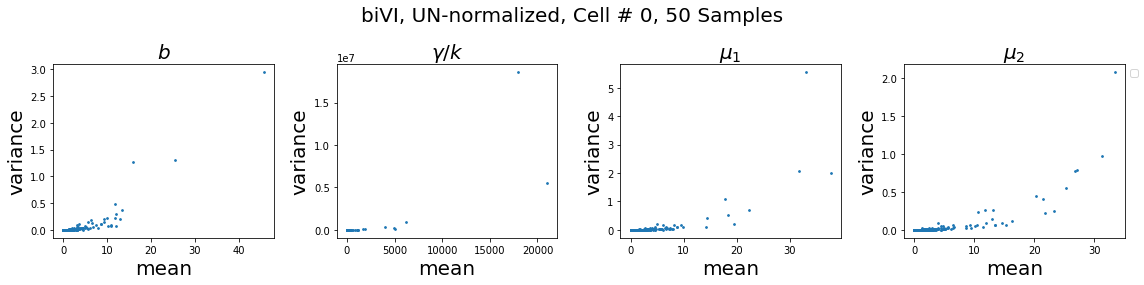

In [577]:
# biVI, UNNORMALIZED

# PLOT

fig,ax = plt.subplots(1,4,figsize=(16,4))
mu1 = biVI_parameters['unspliced_means']
mu2 = biVI_parameters['spliced_means']
b = biVI_parameters['burst_size']
gamma = biVI_parameters['rel_degradation_rate']

    
ax[0].scatter(np.mean(b[:,cell_index,:],axis=0),np.var(b[:,cell_index,:],axis=0),s = 3)
ax[0].set_xlabel('mean', fontsize = fs)
ax[0].set_ylabel('variance', fontsize = fs)
ax[0].set_title('$b$', fontsize = fs)

ax[1].scatter(np.mean(gamma[:,cell_index,:],axis=0),np.var(gamma[:,cell_index,:],axis=0),s = 3)
ax[1].set_xlabel('mean', fontsize = fs)
ax[1].set_ylabel('variance', fontsize = fs)
ax[1].set_title('$\gamma/k$', fontsize = fs)

ax[2].scatter(np.mean(mu1[:,cell_index,:],axis=0),np.var(mu1[:,cell_index,:],axis=0),s = 3)
ax[2].set_xlabel('mean', fontsize = fs)
ax[2].set_ylabel('variance', fontsize = fs)
ax[2].set_title('$\mu_1$', fontsize = fs)

ax[3].scatter(np.mean(mu2[:,cell_index,:],axis=0),np.var(mu2[:,cell_index,:],axis=0),s = 3)
ax[3].set_xlabel('mean', fontsize = fs)
ax[3].set_ylabel('variance', fontsize = fs)
ax[3].set_title('$\mu_2$', fontsize = fs)

    

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.ticklabel_format(axis="both", style="sci")

plt.suptitle(f'biVI, UN-normalized, Cell # {cell_index}, 50 Samples', fontsize = fs)
plt.tight_layout()

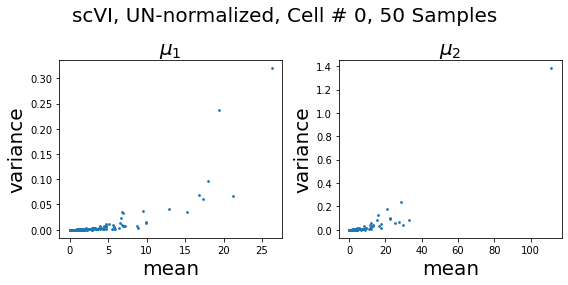

In [579]:
# scVI, UNNORMALIZED

# PLOT

fig,ax = plt.subplots(1,2,figsize=(8,4))
mu1 = scVI_parameters['mean']


    
ax[0].scatter(np.mean(mu[:,cell_index,:2000],axis=0),np.var(mu[:,cell_index,:2000],axis=0),s = 3)
ax[0].set_xlabel('mean', fontsize = fs)
ax[0].set_ylabel('variance', fontsize = fs)
ax[0].set_title('$\mu_1$', fontsize = fs)

    
ax[1].scatter(np.mean(mu[:,cell_index,2000:],axis=0),np.var(mu[:,cell_index,2000:],axis=0),s = 3)
ax[1].set_xlabel('mean', fontsize = fs)
ax[1].set_ylabel('variance', fontsize = fs)
ax[1].set_title('$\mu_2$', fontsize = fs)


    

# plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.ticklabel_format(axis="both", style="sci")

plt.suptitle(f'scVI, UN-normalized, Cell # {cell_index}, 50 Samples', fontsize = fs)
plt.tight_layout()